In [175]:
import xml.etree.ElementTree as ET
import cv2 as cv
import numpy as np
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image

import progressbar

In [126]:
class EdgeBoxes():
    def __init__(self, model_path, max_boxes=30):
        self.edge_detection = cv.ximgproc.createStructuredEdgeDetection(model_path)
        self.edge_boxes = cv.ximgproc.createEdgeBoxes()
        self.edge_boxes.setMaxBoxes(max_boxes)
        # self.model_path = model_path
        # self.max_boxes = max_boxes

    def __call__(self, image, ret_scores=False):
        # self.edge_detection = cv.ximgproc.createStructuredEdgeDetection(self.model_path)
        # self.edge_boxes = cv.ximgproc.createEdgeBoxes()
        # self.edge_boxes.setMaxBoxes(self.max_boxes)
        cv_img = image
        if not isinstance(image, torch.Tensor):
            cv_img = transforms.PILToTensor()(cv_img)
        cv_img = cv_img.permute((1,2,0)).numpy()
        rgb_im = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
        edges = self.edge_detection.detectEdges(np.float32(rgb_im) / 255.0)
        orimap = self.edge_detection.computeOrientation(edges)
        edges = self.edge_detection.edgesNms(edges, orimap)
        boxes = self.edge_boxes.getBoundingBoxes(edges, orimap)

        # OpenCV returns (x, y, w, h). Shift to be (x1, y1, x2, y2)
        for b in boxes[0]:
            b[2] += b[0]
            b[3] += b[1]
            
        if ret_scores:
            return boxes[0], boxes[1]
        
        return boxes[0]

class CustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_boxes = EdgeBoxes(edge_model)
        self.label_names = [
            'background',
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
        ]

        self.eval_mode = eval_mode

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        boxes = self.edge_boxes(image)
        if isinstance(boxes, tuple):
            # print(boxes)
            # boxes = torch.tensor([])
            raise ValueError("Something weird happened here!")
        else:
            boxes = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])

        one_hot_label = torch.zeros(len(self.label_names))
        # one_hot_label = torch.ones(len(self.label_names)) * -1
        for obj in label['annotation']['object']:
            one_hot_label[self.label_names.index(obj['name'])] = 1

        if torch.sum(one_hot_label) == -len(self.label_names):
            # Background
            one_hot_label[0] = 1


        if self.eval_mode:
            gt_boxes = []
            for obj in label['annotation']['object']:
                label_index = self.label_names.index(obj['name'])
                bbox = obj['bndbox']
                gt_boxes.append([
                    int(bbox['xmin']), 
                    int(bbox['ymin']), 
                    int(bbox['xmax']), 
                    int(bbox['ymax']), 
                    label_index, 
                    int(obj['difficult']), 
                    0
                ])

            return image, one_hot_label, boxes, gt_boxes

        return image, one_hot_label, boxes


    def format_pred(self, net_detections):
        """net_detections: the output of WSDDN.detect()"""
        boxes = []
        for label in net_detections.keys():
            for box in net_detections[label]:
                boxes.append([*box[1], label, box[0]])
        
        return boxes


    def draw_boxes(self, image, pred_boxes, gt_boxes):
        """
        GT: [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        Pred: [xmin, ymin, xmax, ymax, class_id, confidence]
        """
        img = image
        if not isinstance(image, torch.Tensor):
            img = transforms.PILToTensor()(image)

        img = img.permute((1,2,0)).numpy()

        for b in pred_boxes:
            x1, y1, x2, y2, class_id, conf = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (255, 0, 0))

        for b in gt_boxes:
            x1, y1, x2, y2, class_id, _, _ = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (0, 255, 0))

        return Image.fromarray(img)
    
    def draw_label(self, img, label, x1, y1, color):
        (label_width, label_height), baseline = cv.getTextSize(label, cv.FONT_HERSHEY_COMPLEX, 0.4, 1)
        back_tl = int(x1), int(y1 - int(1.3 * label_height))
        back_br = int(x1 + label_width), int(y1)
        cv.rectangle(img, back_tl, back_br, color, -1)
        txt_tl = int(x1), int(y1 - int(0.3 * label_height))
        return cv.putText(img, label, txt_tl, cv.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0))


    def draw_raw_boxes(self, image, boxes):
        cv_img_drawn = transforms.PILToTensor()(image)
        cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
        for i, b in enumerate(boxes):
            x1, y1, x2, y2 = b
            cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)

        return Image.fromarray(cv_img_drawn)


In [6]:
custom_voc_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, eval_mode=False, image_set='train')

In [8]:
img, label = super(type(custom_voc_set), custom_voc_set).__getitem__(2)

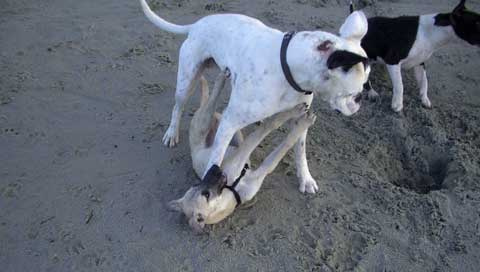

In [9]:
img

In [10]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000019.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '480', 'height': '272', 'depth': '3'},
  'segmented': '1',
  'object': [{'name': 'dog',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '139', 'ymin': '2', 'xmax': '372', 'ymax': '197'},
    'difficult': '0'},
   {'name': 'dog',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '165', 'ymin': '66', 'xmax': '318', 'ymax': '236'},
    'difficult': '0'},
   {'name': 'dog',
    'pose': 'Right',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '361', 'ymin': '1', 'xmax': '480', 'ymax': '112'},
    'difficult': '0'}]}}

In [12]:
folder = '../../../data/VOCdevkit/VOC2012/Annotations/'

In [87]:
tree = ET.parse(folder + '2007_000027.xml')
root = tree.getroot()

In [105]:
test = ET.Element('edge_box')

bbox = ET.SubElement(test, 'bndbox')
xmin = ET.SubElement(bbox, 'xmin')
xmin.text = '1'

ymin = ET.SubElement(bbox, 'ymin')
ymin.text = '2'

xmax = ET.SubElement(bbox, 'xmax')
xmax.text = '3'

ymax = ET.SubElement(bbox, 'ymax')
ymax.text = '4'

bbox = ET.SubElement(test, 'bndbox')
xmin = ET.SubElement(bbox, 'xmin')
xmin.text = '1'

ymin = ET.SubElement(bbox, 'ymin')
ymin.text = '2'

xmax = ET.SubElement(bbox, 'xmax')
xmax.text = '3'

ymax = ET.SubElement(bbox, 'ymax')
ymax.text = '4'

In [106]:
ET.dump(test)

<edge_box><bndbox><xmin>1</xmin><ymin>2</ymin><xmax>3</xmax><ymax>4</ymax></bndbox><bndbox><xmin>1</xmin><ymin>2</ymin><xmax>3</xmax><ymax>4</ymax></bndbox></edge_box>


In [107]:
root.append(test)

In [113]:
import xml.dom.minidom

dom = xml.dom.minidom.parseString(ET.tostring(test))
print(dom.toprettyxml())

<?xml version="1.0" ?>
<edge_box>
	<bndbox>
		<xmin>1</xmin>
		<ymin>2</ymin>
		<xmax>3</xmax>
		<ymax>4</ymax>
	</bndbox>
	<bndbox>
		<xmin>1</xmin>
		<ymin>2</ymin>
		<xmax>3</xmax>
		<ymax>4</ymax>
	</bndbox>
</edge_box>



In [252]:
class OptimizeCustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_boxes = EdgeBoxes(edge_model, max_boxes=20)
    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        boxes = self.edge_boxes(image)
        
        filename = folder + label['annotation']['filename'].replace('.jpg', '.xml')
        tree = ET.parse(filename)
        root = tree.getroot()
        
        for old_edge in root.findall('edge_box'):
            root.remove(old_edge)


        # Create new EdgeBox Element
        edge_box = ET.SubElement(root, 'edge_box')

        for box in boxes:
            bbox = ET.SubElement(edge_box, 'bndbox')
            x1, y1, x2, y2 = box
            
            xmin = ET.SubElement(bbox, 'xmin')
            xmin.text = str(x1)

            ymin = ET.SubElement(bbox, 'ymin')
            ymin.text = str(y1)

            xmax = ET.SubElement(bbox, 'xmax')
            xmax.text = str(x2)

            ymax = ET.SubElement(bbox, 'ymax')
            ymax.text = str(y2)

        # Replace the label with more information
        tree.write(filename)

In [253]:
optimze_voc = OptimizeCustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, eval_mode=False, image_set='train')

In [254]:
with progressbar.ProgressBar(max_value=len(optimze_voc)) as bar:
    for i in range(0, len(optimze_voc)):
        optimze_voc[i]
        bar.update(i)

100% (5717 of 5717) |####################| Elapsed Time: 0:14:20 Time:  0:14:20


In [255]:
optimze_voc = OptimizeCustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, eval_mode=False, image_set='val')

In [256]:
with progressbar.ProgressBar(max_value=len(optimze_voc)) as bar:
    for i in range(0, len(optimze_voc)):
        optimze_voc[i]
        bar.update(i)

100% (5823 of 5823) |####################| Elapsed Time: 0:14:39 Time:  0:14:39


In [285]:
class NewCustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, new_boxes=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_mode = eval_mode
        
        if new_boxes:
            self.edge_boxes = EdgeBoxes(edge_model, max_boxes=20)
        else:
            self.edge_boxes = None

        self.label_names = [
                    'background',
                    'aeroplane',
                    'bicycle',
                    'bird',
                    'boat',
                    'bottle',
                    'bus',
                    'car',
                    'cat',
                    'chair',
                    'cow',
                    'diningtable',
                    'dog',
                    'horse',
                    'motorbike',
                    'person',
                    'pottedplant',
                    'sheep',
                    'sofa',
                    'train',
                    'tvmonitor'
                ]
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        
        if self.edge_boxes is None:
            edge_boxes = label['annotation']['edge_box']['bndbox']
            boxes = np.zeros((len(edge_boxes), 4))
            for i, box in enumerate(edge_boxes):
                boxes[i] = np.array([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
        else:
            boxes = self.edge_boxes(image)

        boxes = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])

        one_hot_label = torch.zeros(len(self.label_names))
        # one_hot_label = torch.ones(len(self.label_names)) * -1
        for obj in label['annotation']['object']:
            one_hot_label[self.label_names.index(obj['name'])] = 1

        if torch.sum(one_hot_label) == -len(self.label_names):
            # Background
            one_hot_label[0] = 1


        if self.eval_mode:
            gt_boxes = []
            for obj in label['annotation']['object']:
                label_index = self.label_names.index(obj['name'])
                bbox = obj['bndbox']
                gt_boxes.append([
                    int(bbox['xmin']), 
                    int(bbox['ymin']), 
                    int(bbox['xmax']), 
                    int(bbox['ymax']), 
                    label_index, 
                    int(obj['difficult']), 
                    0
                ])

            return image, one_hot_label, boxes, gt_boxes

        return image, one_hot_label, boxes


    def format_pred(self, net_detections):
        """net_detections: the output of WSDDN.detect()"""
        boxes = []
        for label in net_detections.keys():
            for box in net_detections[label]:
                boxes.append([*box[1], label, box[0]])
        
        return boxes


    def draw_boxes(self, image, pred_boxes, gt_boxes):
        """
        GT: [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        Pred: [xmin, ymin, xmax, ymax, class_id, confidence]
        """
        img = image
        if not isinstance(image, torch.Tensor):
            img = transforms.PILToTensor()(image)

        img = img.permute((1,2,0)).numpy()

        for b in pred_boxes:
            x1, y1, x2, y2, class_id, conf = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (255, 0, 0))

        for b in gt_boxes:
            x1, y1, x2, y2, class_id, _, _ = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (0, 255, 0))

        return Image.fromarray(img)
    
    def draw_label(self, img, label, x1, y1, color):
        (label_width, label_height), baseline = cv.getTextSize(label, cv.FONT_HERSHEY_COMPLEX, 0.4, 1)
        back_tl = int(x1), int(y1 - int(1.3 * label_height))
        back_br = int(x1 + label_width), int(y1)
        cv.rectangle(img, back_tl, back_br, color, -1)
        txt_tl = int(x1), int(y1 - int(0.3 * label_height))
        return cv.putText(img, label, txt_tl, cv.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0))


    def draw_raw_boxes(self, image, boxes):
        cv_img_drawn = transforms.PILToTensor()(image)
        cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
        for i, b in enumerate(boxes):
            x1, y1, x2, y2 = b
            cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)

        return Image.fromarray(cv_img_drawn)


In [286]:
new_voc = NewCustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, eval_mode=False, image_set='train')

In [287]:
label = new_voc[2]

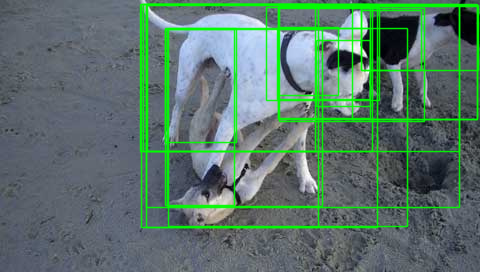

In [288]:
new_voc.draw_raw_boxes(label[0], label[2])